# Uplift-моделирование

## Summary

qini test score:
```
- S-learner:    0.007191009557359775 (0.00719845002189539)
- T-learner:    0.010087308278696368 (0.009967477639333339)
- X-learner:    0.008255681291896536
- R-learner:    0.008169724346340376
- Uplift-trees: 0.00560462419768773
```

## Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression

In [3]:
from metrics import qini_df

---

## Базовые методы uplift-моделирования

### Preprocess

#### Data

Данные можете взять отсюда: https://storage.yandexcloud.net/mle-data/sprint-5/discountuplift.csv.

In [4]:
# загружаем DataFrame

df = pd.read_csv("discountuplift.csv", sep="\t")

In [5]:
df.shape

(12784, 18)

In [6]:
df.head()

,recency,history,used_discount,used_bogo,is_referral,treatment,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web,proba_CN,proba_CR,proba_TN,proba_TR,uplift_score,target_class
0,3,977.51,1,1,1,0,0,0,1,0,0,1,0.476095,0.159710,0.280660,0.083534,-0.043654,0
1,4,391.10,1,0,0,0,1,0,0,1,0,0,0.443035,0.087289,0.285081,0.184594,0.456858,0
2,7,72.37,1,0,1,1,0,0,1,0,0,1,0.514386,0.015488,0.429174,0.040952,0.115756,2
3,10,67.40,1,0,0,1,0,0,1,0,0,1,0.386800,0.125233,0.415839,0.072128,-0.193534,2
4,2,45.68,1,0,1,1,0,0,1,0,1,0,0.517491,0.022507,0.412372,0.047630,0.123726,2


Первое, что нужно сделать, — явно выделить колонки с целевой переменной, факторами и целевым воздействием.

Расшифровка `target_class`:

- `0` — контрольная выборка, не купили товар ($y_c=0$, в наших терминах)
- `1` — контрольная выборка, купили товар ($y_c=1$, в наших терминах)
- `2` — выборка с воздействием (скидка), не купили товар ($y_t=0$, в наших терминах);
- `3` — выборка с воздействием (скидка), купили товар ($y_t=1$, в наших терминах).

#### Preprocess

In [7]:
# добавим признак `old target` — принимает значение 1, если была покупка, и 0 в противном случае
df['old_target'] = df['target_class'] % 2

# выделим колонки с факторами и колонку с фактом «целевого воздействия» — выдачи скидки
feature_cols = ['recency', 'history', 'used_discount', 'used_bogo', 'is_referral',
                'zip_code_Rural', 'zip_code_Surburban', 'zip_code_Urban',
                'channel_Multichannel', 'channel_Phone', 'channel_Web']

In [8]:
target_col = 'old_target'
treatment_col = 'treatment' 

Сколько объектов с классом 1 в целевой переменной?

In [9]:
df[target_col].sum()

1878

In [10]:
pd.concat([df[target_col].value_counts(), df[target_col].value_counts(normalize=True)], axis=1)

,count,proportion
old_target,,
0,10906,0.853098
1,1878,0.146902


Разобъем выборку на тренировочную и тестовую 

In [11]:
df_train, df_test = train_test_split(
    df,
    stratify=df[[treatment_col, target_col]],
    random_state=1,
    test_size=0.25,
)

Чему равна доля значений 1 в целевой переменной из тренировочного датасета? 

In [12]:
df_train[target_col].value_counts(normalize=True)

old_target
0    0.85315
1    0.14685
Name: proportion, dtype: float64

In [13]:
df_test[target_col].value_counts(normalize=True)

old_target
0    0.852941
1    0.147059
Name: proportion, dtype: float64

### S-learner

#### Learn Model

Обучим модель

In [14]:
s_learner = LogisticRegression(random_state=1, max_iter=100_000, n_jobs=-1)

In [15]:
s_learner.fit(
    X=df_train[feature_cols + [treatment_col]],
    y=df_train[target_col],
)

LogisticRegression(max_iter=100000, n_jobs=-1, random_state=1)

In [16]:
s_learner.intercept_

array([-1.36364751])

#### Metrics

In [17]:
# предскажем вероятность покупки, если скидка есть
df_test[treatment_col] = 1
df_test['yes_treatment'] = s_learner.predict_proba(df_test[feature_cols+[treatment_col]])[:,1]

# предскажите вероятность покупки, если скидки нет 
df_test[treatment_col] = 0
df_test['no_treatment'] = s_learner.predict_proba(df_test[feature_cols+[treatment_col]])[:,1]

uplift_vals = df_test['yes_treatment'] - df_test['no_treatment']
df_test['uplift_score'] = uplift_vals

In [18]:
uplift_vals.shape

(3196,)

In [19]:
uplift_vals.head()

8348     0.065262
6137     0.070590
5198     0.070847
11830    0.059890
7148     0.060419
dtype: float64

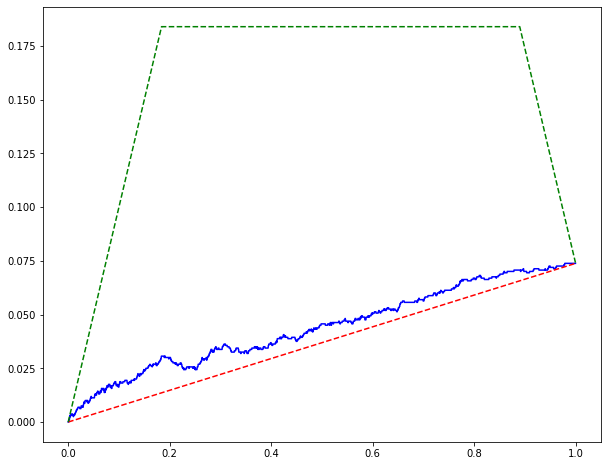

0.00719845002189539

In [20]:
qini_df(df_test, print_optimum=True)

#### Проверить Qini Score на всем наборе данных

In [21]:
df_check = df.copy()

In [22]:
# предскажем вероятность покупки, если скидка есть
df_check[treatment_col] = 1
df_check['yes_treatment'] = s_learner.predict_proba(df_check[feature_cols+[treatment_col]])[:,1]

# предскажите вероятность покупки, если скидки нет 
df_check[treatment_col] = 0
df_check['no_treatment'] = s_learner.predict_proba(df_check[feature_cols+[treatment_col]])[:,1]

df_check['uplift_score'] = df_check['yes_treatment'] - df_check['no_treatment']

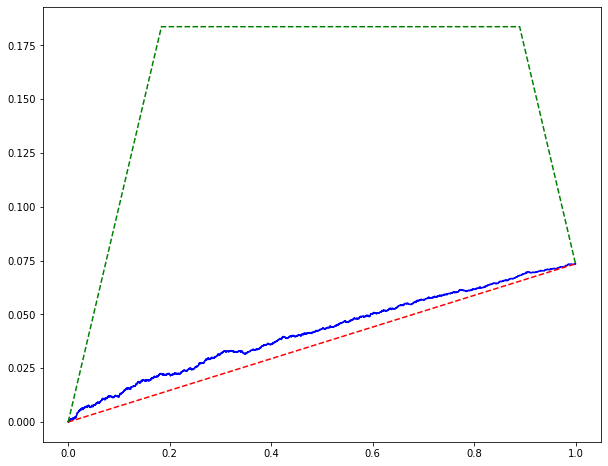

0.005426074794898303

In [23]:
qini_df(df_check, print_optimum=True)

### T-learner

#### Learn Model

In [24]:
t_learner_1 = LogisticRegression(random_state=1, max_iter=100_000, n_jobs=-1)
t_learner_0 = LogisticRegression(random_state=1, max_iter=100_000, n_jobs=-1)

In [25]:
# обучите модели
t_learner_1.fit(
    X=df_train.loc[df_train[treatment_col]==1, feature_cols],
    y=df_train.loc[df_train[treatment_col]==1, target_col]
)

t_learner_0.fit(
    X=df_train.loc[df_train[treatment_col]==0, feature_cols],
    y=df_train.loc[df_train[treatment_col]==0, target_col]
)

LogisticRegression(max_iter=100000, n_jobs=-1, random_state=1)

In [26]:
t_learner_0.intercept_, t_learner_1.intercept_

(array([-2.06532699]), array([-1.06556865]))

#### Metrics

In [27]:
df_test['yes_treatment'] = t_learner_1.predict_proba(df_test[feature_cols])[:,1]
df_test['no_treatment'] = t_learner_0.predict_proba(df_test[feature_cols])[:,1]

uplift_vals = df_test['yes_treatment'] - df_test['no_treatment']
df_test['uplift_score'] = uplift_vals

In [28]:
uplift_vals.shape

(3196,)

In [29]:
uplift_vals.head()

8348     0.036749
6137     0.074309
5198     0.065669
11830    0.065342
7148     0.064211
dtype: float64

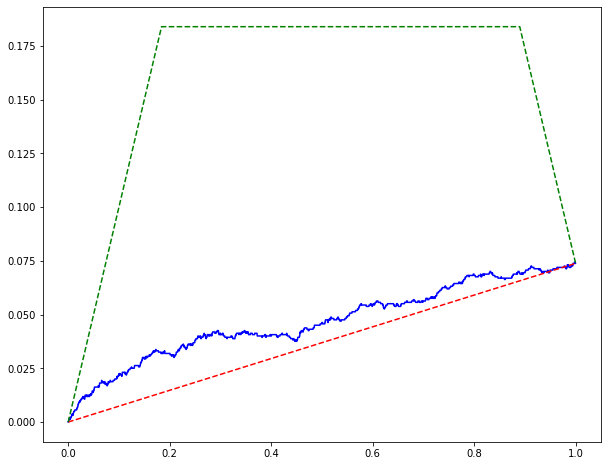

0.009967477639333339

In [30]:
qini_df(df_test, print_optimum=True)

### Библиотека Causal ML

In [31]:
# !pip install causalml

#### S-learner

In [32]:
from causalml.inference.meta import BaseSClassifier

In [33]:
s_learner = BaseSClassifier(
    learner=LogisticRegression(random_state=1, max_iter=100_000, verbose=0)
)

In [34]:
# для обучения нам нужны датафрейм с факторами и колонка с фактом воздействия
s_learner.fit(
    X=df_train[feature_cols],
    treatment=df_train[treatment_col],
    y=df_train[target_col],
)

In [35]:
uplift_vals = s_learner.predict(np.array(df_test[feature_cols].values.copy()))

In [36]:
uplift_vals.shape

(3196, 1)

In [37]:
uplift_vals

array([[0.06509367],
       [0.07042173],
       [0.07063039],
       ...,
       [0.05428119],
       [0.0423286 ],
       [0.07178269]])

In [38]:
df_test['uplift_score'] = uplift_vals

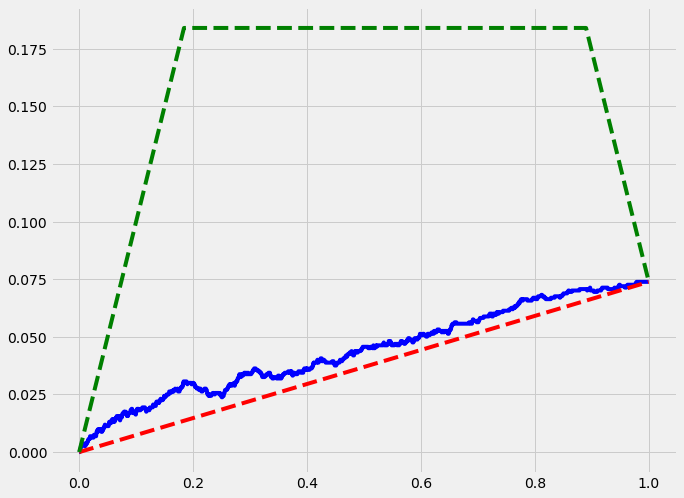

0.007191009557359775

In [39]:
qini_df(df_test, print_optimum=True)

#### T-learner

In [40]:
from causalml.inference.meta import BaseTClassifier

In [41]:
t_learner = BaseTClassifier(
    learner=LogisticRegression(random_state=1, max_iter=100_000, verbose=0)
)

In [42]:
# для обучения нам нужны датафрейм с факторами и колонка с фактом воздействия
t_learner.fit(
    X=df_train[feature_cols],
    treatment=df_train[treatment_col],
    y=df_train[target_col]
)

In [43]:
uplift_vals = t_learner.predict(np.array(df_test[feature_cols].values.copy()))

In [44]:
uplift_vals.shape

(3196, 1)

In [45]:
uplift_vals

array([[0.03564954],
       [0.07373987],
       [0.06509747],
       ...,
       [0.05584663],
       [0.07095049],
       [0.09431702]])

In [46]:
df_test['uplift_score'] = uplift_vals

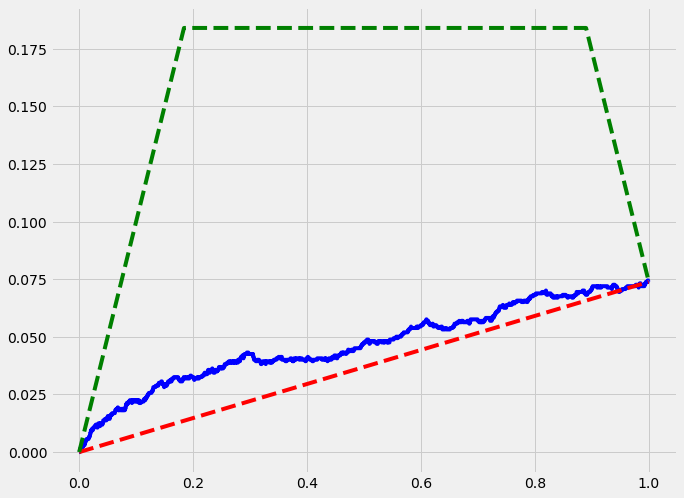

0.010087308278696368

In [47]:
qini_df(df_test, print_optimum=True)

---

## Продвинутые методы uplift-моделирования

### Preprocess

#### Data

Данные можете взять отсюда: https://storage.yandexcloud.net/mle-data/sprint-5/discountuplift.csv.

In [4]:
# загружаем DataFrame

df = pd.read_csv("discountuplift.csv", sep="\t")

In [5]:
df.shape

(12784, 18)

In [6]:
df.head()

,recency,history,used_discount,used_bogo,is_referral,treatment,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web,proba_CN,proba_CR,proba_TN,proba_TR,uplift_score,target_class
0,3,977.51,1,1,1,0,0,0,1,0,0,1,0.476095,0.159710,0.280660,0.083534,-0.043654,0
1,4,391.10,1,0,0,0,1,0,0,1,0,0,0.443035,0.087289,0.285081,0.184594,0.456858,0
2,7,72.37,1,0,1,1,0,0,1,0,0,1,0.514386,0.015488,0.429174,0.040952,0.115756,2
3,10,67.40,1,0,0,1,0,0,1,0,0,1,0.386800,0.125233,0.415839,0.072128,-0.193534,2
4,2,45.68,1,0,1,1,0,0,1,0,1,0,0.517491,0.022507,0.412372,0.047630,0.123726,2


Первое, что нужно сделать, — явно выделить колонки с целевой переменной, факторами и целевым воздействием.

Расшифровка `target_class`:

- `0` — контрольная выборка, не купили товар ($y_c=0$, в наших терминах)
- `1` — контрольная выборка, купили товар ($y_c=1$, в наших терминах)
- `2` — выборка с воздействием (скидка), не купили товар ($y_t=0$, в наших терминах);
- `3` — выборка с воздействием (скидка), купили товар ($y_t=1$, в наших терминах).

#### Preprocess

In [7]:
# добавим признак `old target` — принимает значение 1, если была покупка, и 0 в противном случае
df['old_target'] = df['target_class'] % 2

# выделим колонки с факторами и колонку с фактом «целевого воздействия» — выдачи скидки
feature_cols = ['recency', 'history', 'used_discount', 'used_bogo', 'is_referral',
                'zip_code_Rural', 'zip_code_Surburban', 'zip_code_Urban',
                'channel_Multichannel', 'channel_Phone', 'channel_Web']

In [8]:
target_col = 'old_target'
treatment_col = 'treatment' 

Сколько объектов с классом 1 в целевой переменной?

In [9]:
df[target_col].sum()

1878

In [10]:
pd.concat([df[target_col].value_counts(), df[target_col].value_counts(normalize=True)], axis=1)

,count,proportion
old_target,,
0,10906,0.853098
1,1878,0.146902


Разобъем выборку на тренировочную и тестовую 

In [11]:
df_train, df_test = train_test_split(
    df,
    stratify=df[[treatment_col, target_col]],
    random_state=1,
    test_size=0.25,
)

Чему равна доля значений 1 в целевой переменной из тренировочного датасета? 

In [12]:
df_train[target_col].value_counts(normalize=True)

old_target
0    0.85315
1    0.14685
Name: proportion, dtype: float64

In [13]:
df_test[target_col].value_counts(normalize=True)

old_target
0    0.852941
1    0.147059
Name: proportion, dtype: float64

### X-learner

In [14]:
from causalml.inference.meta import BaseXClassifier

In [15]:
# создадим базовый X-learner

x_learner = BaseXClassifier(
    outcome_learner=LogisticRegression(max_iter=1_000_000, random_state=13),
    effect_learner=LinearRegression(),
)

In [16]:
# для обучения нам нужны датафрейм с факторами и колонка с фактом воздействия
x_learner.fit(
    X=df_train[feature_cols],
    treatment=df_train[treatment_col],
    y=df_train[target_col],
)

The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the

In [17]:
uplift_vals = x_learner.predict(np.array(df_test[feature_cols].values.copy()))

In [18]:
uplift_vals.shape

(3196, 1)

In [19]:
uplift_vals

array([[0.02142142],
       [0.07179297],
       [0.06358299],
       ...,
       [0.05321857],
       [0.08256778],
       [0.0900808 ]])

In [20]:
df_test['uplift_score'] = uplift_vals

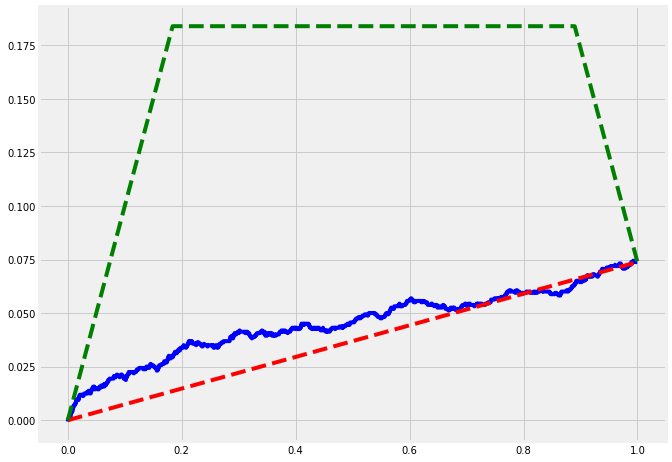

0.008255681291896536

In [21]:
qini_df(df_test, print_optimum=True)

### R-learner

In [22]:
from causalml.inference.meta import BaseRClassifier

In [23]:
# создадим базовый R-learner

r_learner = BaseRClassifier(
    outcome_learner=LogisticRegression(max_iter=1_000_000, random_state=13),
    effect_learner=LinearRegression(),
)

In [24]:
# для обучения нам нужны датафрейм с факторами и колонка с фактом воздействия
r_learner.fit(
    X=df_train[feature_cols],
    treatment=df_train[treatment_col],
    y=df_train[target_col],
)

The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the

In [25]:
uplift_vals = r_learner.predict(np.array(df_test[feature_cols].values.copy()))

In [26]:
uplift_vals.shape

(3196, 1)

In [27]:
uplift_vals

array([[0.02098655],
       [0.07241932],
       [0.06455629],
       ...,
       [0.05225659],
       [0.08368418],
       [0.09183452]])

In [28]:
df_test['uplift_score'] = uplift_vals

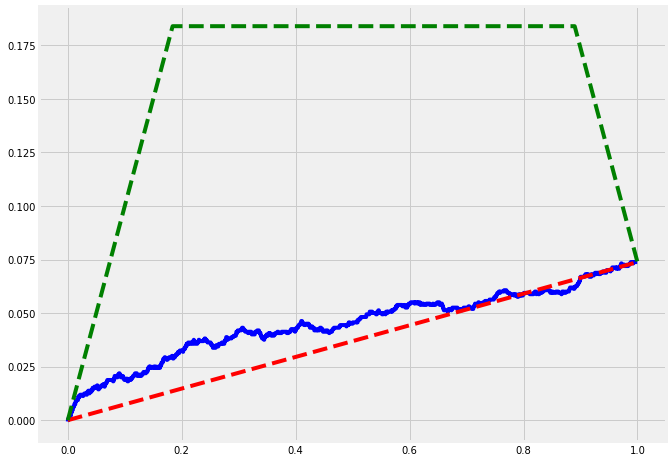

0.008169724346340376

In [29]:
qini_df(df_test, print_optimum=True)

### Uplift-деревья

In [30]:
from causalml.inference.tree import UpliftTreeClassifier

In [31]:
# создадим базовое uplift-дерево
uplift_model = UpliftTreeClassifier(
    max_depth=5,
    min_samples_leaf=200,
    min_samples_treatment=50,
    n_reg=100,
    evaluationFunction='ED',
    control_name='0',
)

In [32]:
uplift_model.fit(
    X=df_train[feature_cols].values,
    treatment=df_train[treatment_col].apply(str).values,
    y=df_train[target_col].values
)

In [33]:
uplift_vals = uplift_model.predict(np.array(df_test[feature_cols].values.copy()))

In [34]:
df_res = pd.DataFrame(uplift_vals, columns=uplift_model.classes_)

In [35]:
df_res.head()

,0,1
0,0.082667,0.204724
1,0.124585,0.216667
2,0.124585,0.216667
3,0.124585,0.216667
4,0.124585,0.216667


In [36]:
uplift_vals.shape

(3196, 2)

In [37]:
uplift_vals

array([[0.08266667, 0.20472441],
       [0.12458472, 0.21666667],
       [0.12458472, 0.21666667],
       ...,
       [0.08860759, 0.07142857],
       [0.07232704, 0.14936709],
       [0.12458472, 0.21666667]])

In [38]:
df_test['uplift_score'] = uplift_vals

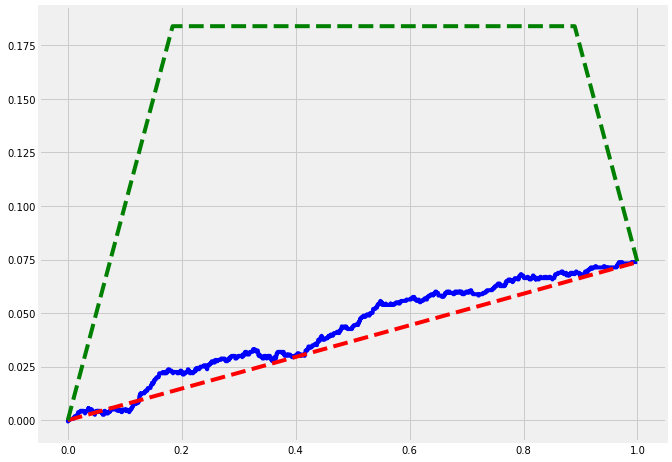

0.00560462419768773

In [39]:
qini_df(df_test, print_optimum=True)

---

In [40]:
uplift_vals = uplift_vals[:,1] - uplift_vals[:,0]

In [41]:
uplift_vals.shape

(3196,)

In [42]:
uplift_vals

array([ 0.12205774,  0.09208195,  0.09208195, ..., -0.01717902,
        0.07704004,  0.09208195])

In [43]:
df_test['uplift_score'] = uplift_vals

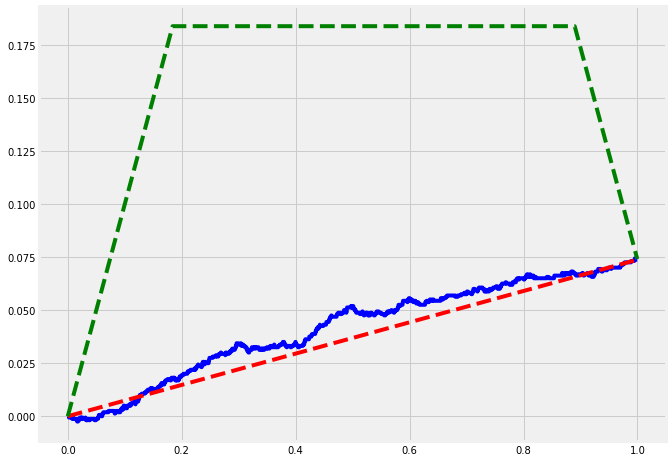

0.0047362436657023416

In [44]:
qini_df(df_test, print_optimum=True)

---

### Uplift-деревья default

In [45]:
# создадим базовое uplift-дерево
uplift_model = UpliftTreeClassifier("0")

In [46]:
uplift_model.fit(
    X=df_train[feature_cols].values,
    treatment=df_train[treatment_col].apply(str).values,
    y=df_train[target_col].values
)

In [47]:
uplift_vals = uplift_model.predict(np.array(df_test[feature_cols].values.copy()))

In [48]:
df_res = pd.DataFrame(uplift_vals, columns=uplift_model.classes_)

In [49]:
df_res.head()

,0,1
0,0.119888,0.190416
1,0.119888,0.190416
2,0.119888,0.190416
3,0.119888,0.190416
4,0.169811,0.214689


In [50]:
uplift_vals.shape

(3196, 2)

In [51]:
uplift_vals

array([[0.11988761, 0.19041614],
       [0.11988761, 0.19041614],
       [0.11988761, 0.19041614],
       ...,
       [0.11988761, 0.19041614],
       [0.04526749, 0.13598901],
       [0.11988761, 0.19041614]])

In [52]:
df_test['uplift_score'] = uplift_vals

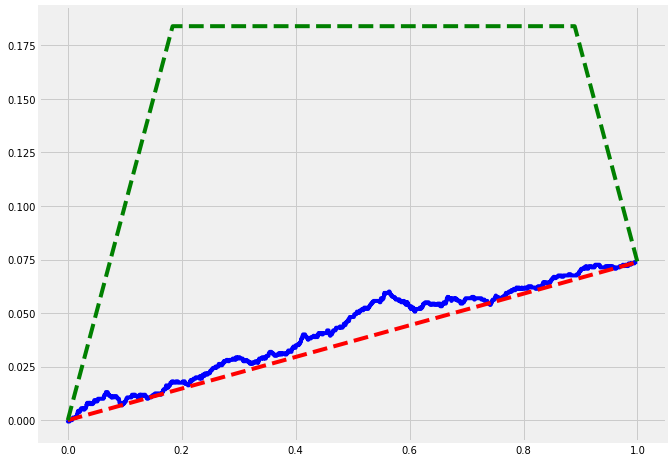

0.004931653760611346

In [53]:
qini_df(df_test, print_optimum=True)

---

In [54]:
uplift_vals = uplift_vals[:,1] - uplift_vals[:,0]

In [55]:
uplift_vals.shape

(3196,)

In [56]:
uplift_vals

array([0.07052854, 0.07052854, 0.07052854, ..., 0.07052854, 0.09072152,
       0.07052854])

In [57]:
df_test['uplift_score'] = uplift_vals

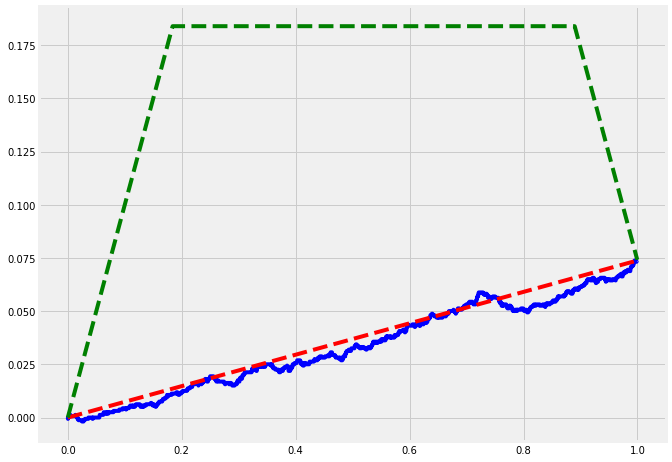

-0.003429078757038226

In [58]:
qini_df(df_test, print_optimum=True)